In [1]:
import torch
import torchvision
torch.__version__

'1.3.1+cpu'

In [2]:
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
from IPython.display import clear_output

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode

import random

In [5]:
MODEL_DIR = '../models/2/'
DATA_PATH = '../data/interim/training/_coco_data3/'

_test_jsn, _test_dir = "{}test.json".format(DATA_PATH), "{}test".format(DATA_PATH)
_train_jsn, _train_dir = "{}train.json".format(DATA_PATH), "{}train".format(DATA_PATH)

if os.path.exists(_train_dir) and os.path.exists(_train_jsn):
    register_coco_instances("train_cells", {}, _train_jsn, _train_dir)
else:
    print('fuck you')

if os.path.exists(_test_dir) and os.path.exists(_test_jsn):
    register_coco_instances("test_cells", {}, _test_jsn, _test_dir)
else:
    print('fuck you too')

In [6]:
train_metadata = MetadataCatalog.get("train_cells")
train_dicts = DatasetCatalog.get("train_cells")

test_metadata = MetadataCatalog.get("test_cells")
test_dicts = DatasetCatalog.get("test_cells")

WARNING [02/11 15:44:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/11 15:44:35 d2.data.datasets.coco]: Loaded 146 images in COCO format from ../data/interim/training/_coco_data3/train.json
WARNING [02/11 15:44:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/11 15:44:35 d2.data.datasets.coco]: Loaded 62 images in COCO format from ../data/interim/training/_coco_data3/test.json


In [9]:
cfg = get_cfg()

cfg.merge_from_file("../src/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# cfg.DATASETS.TRAIN = ("fruits_nuts",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.MODEL.WEIGHTS = os.path.join(MODEL_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("fruits_nuts", )
cfg.MODEL.DEVICE = 'cpu'
predictor = DefaultPredictor(cfg)

WARNING [02/11 15:46:06 d2.config.compat]: Config '../src/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


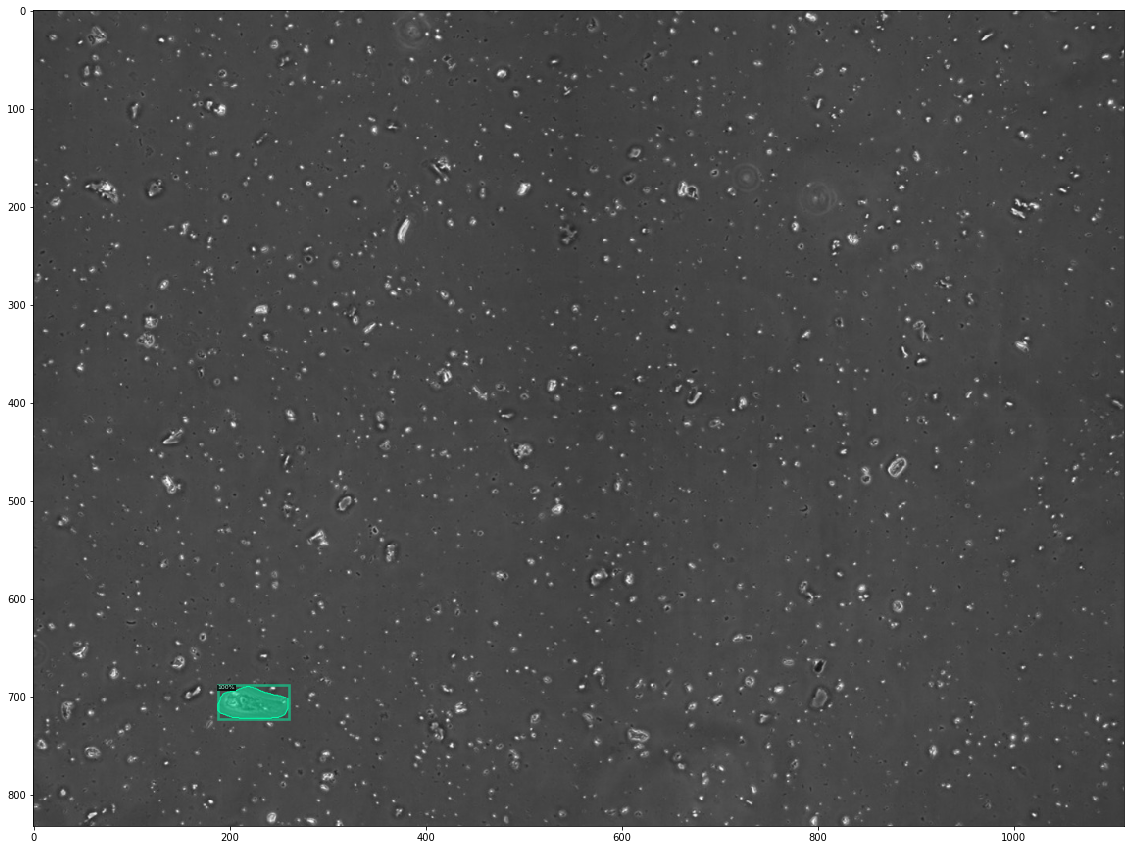

In [48]:
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata, 
                   scale=0.8, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"])
    
    figure(figsize=(21, 15))
    imshow(v.get_image()[:, :, ::-1])
    show()

In [42]:
TEST_DIR = '../data/interim/K_labeling/2/'
test_K6 = glob.glob(TEST_DIR + '*')

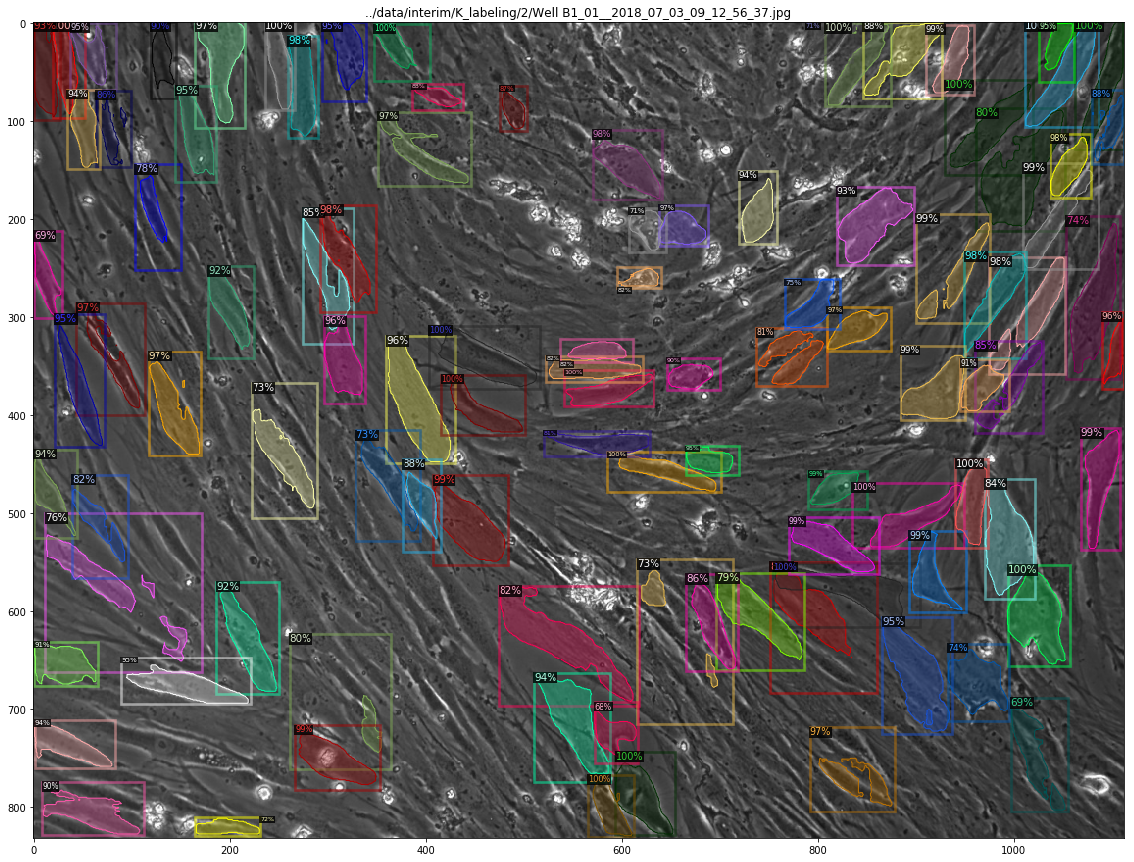

../data/interim/K_labeling/2/Well B1_01__2018_07_03_09_12_56_37.jpg
CPU times: user 16.6 s, sys: 952 ms, total: 17.6 s
Wall time: 10.2 s


In [47]:
%%time
for d in random.sample(test_K6, 1):    
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"])
    
    figure(figsize=(21, 15))
    title(d)
    imshow(v.get_image()[:, :, ::-1])
    show()
print(d)

## Evaluation using the trained model

In [10]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("test_cells", cfg, False, output_dir="../models/2/output_test/")
val_loader = build_detection_test_loader(cfg, "test_cells")

inference_on_dataset(predictor.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [02/11 15:49:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/11 15:49:00 d2.data.datasets.coco]: Loaded 62 images in COCO format from ../data/interim/training/_coco_data3/test.json
[02/11 15:49:00 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 1569         |
|            |              |
[02/11 15:49:00 d2.evaluation.evaluator]: Start inference on 62 images


KeyboardInterrupt: 

## Benchmark inference speed

In [53]:
import time
times = []
for i in range(10):
    print ("Loading" + "." * i, end="\r")
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))
# Average(sec):0.10,fps:10.12 # from colab

Average(sec):6.24,fps:0.16


### В 60 раз медленнее, чем на колабовских гпухах

- проверить качестве на тесте
- загрузить пикчи в диск
- сделать авторазметку и сунуть ее в таблицы или json'ы

In [75]:
import math
_NPic = 100000
_ava_time_one = 6.5 # sec
'{} hours ({} days) for labeling {} pics'.format(round(_ava_time_one * _NPic / 3600), 
                                                 math.ceil(_ava_time_one * _NPic / 3600 / 24), 
                                                 _NPic)

'181 hours (8 days) for labeling 100000 pics'